*RISE source code* - https://github.com/eclique/RISE/blob/master/Easy_start.ipynb

In [1]:
import os
import numpy as np

from tqdm import tqdm
from matplotlib import pyplot as plt
from skimage.transform import resize

from tensorflow.keras import preprocessing

from PIL import Image

In [2]:
def load_image(path, input_size):
    img = preprocessing.image.load_img(path, target_size=input_size)
    x = preprocessing.image.img_to_array(img)
    return img, x

In [3]:
def apply_mask(image, mask):
    data = image * mask
    img = Image.fromarray(data.astype(np.uint8), 'RGB')
    return img

In [4]:
def show_mask(mask, input_size):
    w, h = input_size
    image = 255 * np.ones((h, w, 3), dtype=np.uint8)
    return apply_mask(image, mask)

In [5]:
def get_binary_mask(grid, shift, s, input_size):
    mask_size, cell_size, over_size = get_grid_size(s, input_size)
    new_grid = np.zeros(mask_size)

    for y in range(0, new_grid.shape[0]):
        for x in range(0, new_grid.shape[1]):
            grid_y = int(y // cell_size[0])
            grid_x = int(x // cell_size[1])

            new_grid[y][x] = grid[grid_y][grid_x]
    
    new_grid = new_grid[shift[0]:input_size[0] + shift[0], shift[1]:input_size[1] + shift[1]]

    return new_grid.reshape(*input_size, 1)

In [6]:
def show_grid_as_binary_mask(grid, shift, s, input_size):
    binary_mask = get_binary_mask(grid, shift, s, input_size)
    return show_mask(binary_mask, (binary_mask.shape[0], binary_mask.shape[1]))

In [7]:
def get_grid_size(s, input_size):
    # the size of one pixel (rectangle)
    cell_size = np.ceil(np.array(input_size) / s)
    
    # the additional size for each rectangle
    # sinze we do a crop from the mask, we
    # need to make a "bigger" mask
    # we calculate how much we need to increase the cell
    # to have one additional cell
    over_cell_size = np.ceil((((s + 1) * cell_size) - (s * cell_size)) / s)
    
    # new cell size
    new_cell_size = cell_size + over_cell_size
    
    # mask size (mask is larger than the image)
    mask_size = (s * new_cell_size).astype(np.uint32)
    
    # difference in size between original image and mask
    over_image_size = mask_size - input_size
    
    return mask_size, new_cell_size, over_image_size

In [8]:
def generate_masks(N, s, p1, input_size):
    mask_size, cell_size, over_image_size = get_grid_size(s, input_size)

    grids = np.random.rand(N, s, s) < p1
    grids = grids.astype('float32')

    masks = np.empty((N, *input_size))
    shifts = np.empty((N, 2), dtype=np.uint32)

    for i in tqdm(range(N), desc='Generating masks'):
        # Random shifts
        x = np.random.randint(0, over_image_size[0])
        y = np.random.randint(0, over_image_size[1])

        # Linear upsampling and cropping
        shifts[i] = [x, y]
        masks[i, :, :] = resize(grids[i], mask_size, order=1, mode='reflect', anti_aliasing=False)[x:x + input_size[0], y:y + input_size[1]]
        
    masks = masks.reshape(-1, *input_size, 1)
    
    return grids, shifts, masks

### Load image

In [9]:
input_size = [300, 300]
image, image_data = load_image('../data/catdog.png', input_size)

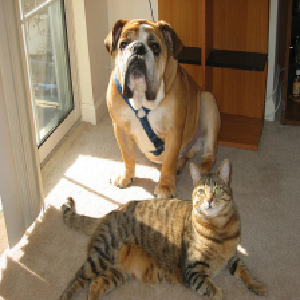

In [10]:
image

### Generate some masks

In [11]:
N = 100
s = 8
p = 0.5

grids, shifts, upsampled_masks = generate_masks(N, s, p, input_size)

Generating masks: 100%|██████████| 100/100 [00:00<00:00, 213.41it/s]


### Show mask

In [12]:
grid = grids[0]
shift = shifts[0]

print(grid.shape)
print(grid)

(8, 8)
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 0. 1. 1. 1. 0. 0. 1.]
 [1. 1. 1. 0. 0. 1. 0. 1.]
 [0. 1. 1. 0. 0. 1. 0. 0.]
 [0. 1. 1. 1. 1. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [1. 1. 1. 0. 0. 0. 1. 1.]
 [1. 0. 0. 1. 1. 0. 0. 0.]]


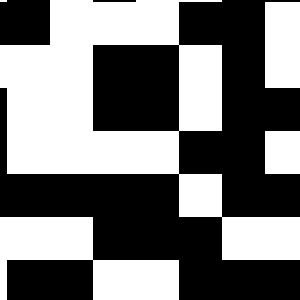

In [14]:
show_grid_as_binary_mask(grid, shift, s, input_size)

### Show mask (upsampled)

In [16]:
upsampled_mask = upsampled_masks[0]

print(upsampled_mask.shape)

(300, 300, 1)


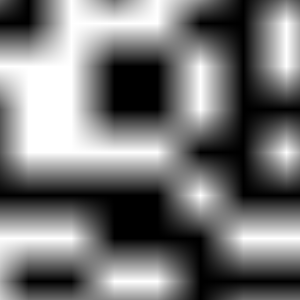

In [17]:
show_mask(upsampled_mask, input_size)

### Apply mask

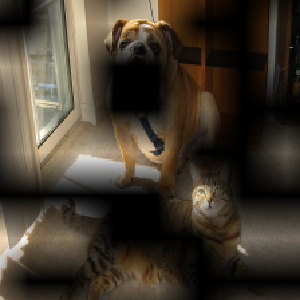

In [19]:
apply_mask(image_data, upsampled_mask)

## Prototyping

In [96]:
N = 100
s = 8
p = 0.75

grids, shifts, upsampled_masks = generate_masks(N, s, p, input_size)

Generating masks: 100%|██████████| 100/100 [00:00<00:00, 208.57it/s]


In [97]:
upsampled_mask = upsampled_masks[5]
grid = grids[5]
shift = shifts[5]

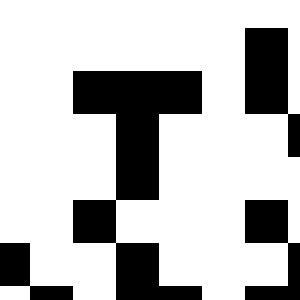

In [98]:
show_grid_as_binary_mask(grid, shift, s, input_size)

In [99]:
binary_mask = get_binary_mask(grid, shift, s, input_size)

In [100]:
def defect_image(image, mask):
    image_defect = image.copy()
    for layer in range(image_defect.shape[-1]):
        image_defect[np.where(mask)] = 0
    return image_defect

In [101]:
defected_image = defect_image(image_data, binary_mask)

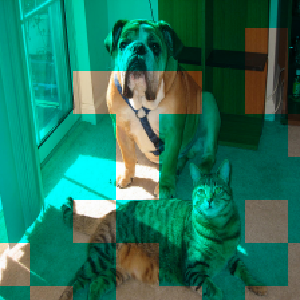

In [102]:
Image.fromarray(defected_image.astype(np.uint8), 'RGB')

In [103]:
import cv2

In [123]:
new_binary_mask = binary_mask.reshape(binary_mask.shape[0], binary_mask.shape[1])

algorithm = cv2.INPAINT_NS
# algorithm = cv2.INPAINT_TELEA

inpaint_radius = 20

inpainted_image = cv2.inpaint(image_data.astype(np.uint8), 1 - new_binary_mask.astype(np.uint8), inpaint_radius, algorithm)

In [124]:
inpainted_image.shape

(300, 300, 3)

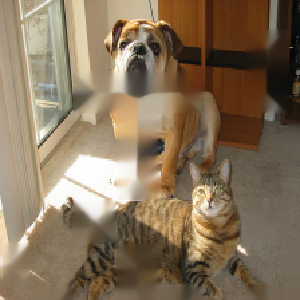

In [126]:
Image.fromarray(inpainted_image.astype(np.uint8), 'RGB')

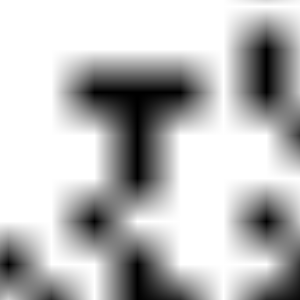

In [127]:
show_mask(upsampled_mask, input_size)

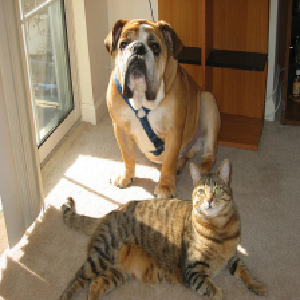

In [128]:
image